In [24]:
# Mount to drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Link to the directory of folder.
%cd /content/drive/MyDrive/hanlhn/Problem

/content/drive/.shortcut-targets-by-id/1xP_CCNA2iBFpmQU0YLdkhiDjQ9ZvTNtW/hanlhn/Problem


In [26]:
#!unzip 'problem2-data/archive.zip' 

In [27]:
import os
import numpy as np
import cv2
import torch
import random
import queue
from itertools import cycle
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm
import multiprocessing
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
class CFG:
    '''
    CFG
    Define hyperparameters used for preprocessing data and training model
    ----------
    Attributes
    ----------
        num_epochs: int 
            Number of epochs need for training.
        batch_size: int
            Number of samples used for training in 1 iteration.
        mean: ndarray
            Mean values of the whole dataset
        std: ndarray
            Standard deviation values of the whole dataset.
        height: int
            Height of input image used for the input layer of model.
        width: int
            Width of input image used for the input layer of model.
        learning_rate: float
            Step size at each iteration defines how much to change the model.
        num_classes: int
            Number of output classes.
        target_names: list(str) 
            Names of output classes.
    '''
    num_epochs = 10
    batch_size = 32
    num_workers = 2
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    height = 224
    width = 224
    learning_rate = 0.001
    num_classes = 4
    path = 'data'
    stoi = {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    itos = {0 :'cloudy', 1 : 'desert', 2 : 'green_area', 3 : 'water'}
    target_names = ['cloudy', 'desert', 'green_area', 'water']

In [30]:
def random_split_dataset(path = CFG.path):
    '''
    random_split_dataset(path = CFG.path)
    Split the dataset into 3 subsets included: train, validation and test.
    ----------
    Parameters
    ----------
    path : str, default=CFG.path
        `path` define the path to dataset
    ----------
    Returns
    ----------
    tuple(list(str))
        Tuple including 3 lists: train, validation, test. Each list contains paths to samples in dataset.
        The default ratio for 3 subset: train=0.6, validation=0.2, test=0.2
    '''
    data = []
    for classname in os.listdir(path):
        for filename in os.listdir(os.path.join(path, classname)):
            data.append((filename, classname))
    print('Length dataset', len(data))
    CFG.train_size = int(0.6 * len(data))
    CFG.valid_size = int(0.2 * len(data))
    CFG.test_size = len(data) - CFG.train_size - CFG.valid_size
    random.shuffle(data)
    return (data[:CFG.train_size], 
            data[CFG.train_size : CFG.train_size + CFG.valid_size], 
            data[CFG.train_size + CFG.valid_size:])

In [31]:
class DataProcess(Dataset):
    '''
    DataProcess
        
    '''
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, idx: int) -> tuple:
        '''
        __getitem__(self, idx)
        Get item by index
        ----------
        Parameters
        ----------
        idx: int
            Index of the item you want to get.
        ----------
        Returns
        ----------
        A tuple of (image, label: numeric)
        '''
        filename, classname = self.data[idx]
        image_path = os.path.join(CFG.path,classname,filename)
        image = np.array(Image.open(image_path).convert("RGB"))
        image = cv2.resize(image,(CFG.width, CFG.height))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2,0,1))/255
        for i in range(3):
            image[i,:,:]=(image[i,:,:]-CFG.mean[i])/CFG.std[i]
        return np.array(image, dtype = np.float32), np.array(CFG.stoi[classname])

    def __len__(self):
        '''
        __len__(self)
        Number of samples in the dataset.
        '''
        return len(self.data)

In [32]:
def default_collate(batch):
    '''
    default_collate(batch)
    Define the methods to concatenate items in the batch.
    '''
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    if isinstance(batch[0], (int, float)):
        return np.array(batch)
    if isinstance(batch[0], (list, tuple)):
        return tuple(torch.tensor(default_collate(var)) for var in zip(*batch))

In [33]:
class DataLoader:
    def __init__(self, dataset, batch_size=64, collate_fn=default_collate):
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn
        self.index = 0

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self.dataset):
            # stop iteration once index is out of bounds
            raise StopIteration
        batch_size = min(len(self.dataset) - self.index, self.batch_size)
        return self.collate_fn([self.get() for _ in range(batch_size)])

    def get(self):
        item = self.dataset[self.index]
        self.index += 1
        return item

In [34]:
train_data,val_data,test_data = random_split_dataset()
train_dataset = DataProcess(train_data)
val_dataset = DataProcess(val_data)
test_dataset = DataProcess(test_data)

Length dataset 5631


In [35]:
for i in train_dataset:
    print(len(i))
    break

2


In [36]:
train_loader = DataLoader(dataset = train_dataset, batch_size = CFG.batch_size)
val_loader = DataLoader(dataset = val_dataset, batch_size = CFG.batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = CFG.batch_size)

In [37]:
for i,j in train_loader:
    print(i.shape,j.shape)
    print(type(i),type(j))
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [38]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Sequential(
                                    nn.Linear(self.model.classifier[6].in_features, 512), 
                                    nn.Linear(512, CFG.num_classes))

        self.model = self.model.to(device, dtype=torch.float)

    def forward(self, x):
        return self.model(x)

In [39]:
class Trainer:
    def __init__(self, model):
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=CFG.learning_rate, momentum=0.9)

    def train(self, train_loader):
        self.model.train()
        train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            train_loss += loss.item()

            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                
            # accuracy
            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_train += (labels == predicted).sum().item()
            train_acc = (100 * correct_train) / target_count
        return train_acc, train_loss / target_count

    def validate(self, val_loader):
        self.model.eval()
        val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_val += (labels == predicted).sum().item()
            val_acc = (100 * correct_val) / target_count
        return val_acc, val_loss / target_count 
    
    def fit(self, model, the_last_loss = 100, patience = 10, trigger_times = 0, isStopped = False):
        self.train_acc_history = []
        self.train_loss_history = []
        self.val_acc_history = []
        self.val_loss_history = []

        for epoch in range(0, CFG.num_epochs):
            
            train_acc, train_loss = self.train(train_loader)
            self.train_acc_history.append(train_acc)
            self.train_loss_history.append(train_loss)
            
            val_acc,val_loss = self.validate(val_loader)
            self.val_acc_history.append(val_acc)
            self.val_loss_history.append(val_loss)
            
            print("Epoch {}: train_acc {:.6f} \t train_loss {:.6f} \t val_acc {:.6f} \t val_loss {:.6f}".format(epoch+1, train_acc, train_loss, val_acc, val_loss))
            print("Learning rate: {}".format(self.optimizer.param_groups[0]["lr"]))
            the_current_loss = val_loss
            
            if the_current_loss > the_last_loss:
                trigger_times += 1
                print('trigger times: ', trigger_times)
                if trigger_times >= patience:
                    print('Early stopping! at epoch {0}'.format(epoch+1))
                    isStopped = True
                    break
            else:
                print('trigger times: 0')
                trigger_times = 0
                the_last_loss = the_current_loss
                if not isStopped:
                    torch.save(self.model.state_dict(), 'model.pt')
                    print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

    def plot_his_acc(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_acc_history,'-o')
        plt.plot(self.val_acc_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Acc','Val_Acc'])
        plt.title('Train Acc and Val Acc')
        plt.show()

    def plot_his_loss(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_loss_history,'-o')
        plt.plot(self.val_loss_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('losses')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Loss','Val_Loss'])
        plt.title('Train Loss and Val Loss')
        plt.show()

In [40]:
model = BaseModel()
trainer = Trainer(model)

In [41]:
trainer.fit(model)

106it [01:47,  1.02s/it]
36it [00:12,  2.87it/s]


Epoch 1: train_acc 69.242155 	 train_loss 0.021700 	 val_acc 72.912966 	 val_loss 0.015551
Learning rate: 0.001
trigger times: 0
Validation loss 0.015551.  Saving model ...


106it [01:47,  1.01s/it]
36it [00:12,  2.86it/s]


Epoch 2: train_acc 84.162226 	 train_loss 0.011646 	 val_acc 85.612789 	 val_loss 0.009514
Learning rate: 0.001
trigger times: 0
Validation loss 0.009514.  Saving model ...


106it [01:47,  1.01s/it]
36it [00:12,  2.86it/s]


Epoch 3: train_acc 98.401421 	 train_loss 0.001621 	 val_acc 99.733570 	 val_loss 0.000340
Learning rate: 0.001
trigger times: 0
Validation loss 0.000340.  Saving model ...


106it [01:47,  1.02s/it]
36it [00:12,  2.86it/s]


Epoch 4: train_acc 98.904677 	 train_loss 0.001190 	 val_acc 99.378330 	 val_loss 0.000595
Learning rate: 0.001
trigger times:  1


106it [01:47,  1.02s/it]
36it [00:12,  2.87it/s]


Epoch 5: train_acc 98.608644 	 train_loss 0.001550 	 val_acc 99.733570 	 val_loss 0.000398
Learning rate: 0.001
trigger times:  2


106it [01:47,  1.02s/it]
36it [00:12,  2.86it/s]


Epoch 6: train_acc 99.674364 	 train_loss 0.000361 	 val_acc 99.733570 	 val_loss 0.000339
Learning rate: 0.001
trigger times: 0
Validation loss 0.000339.  Saving model ...


106it [01:47,  1.02s/it]
36it [00:12,  2.88it/s]


Epoch 7: train_acc 99.763173 	 train_loss 0.000268 	 val_acc 100.000000 	 val_loss 0.000022
Learning rate: 0.001
trigger times: 0
Validation loss 0.000022.  Saving model ...


106it [01:47,  1.02s/it]
36it [00:12,  2.85it/s]


Epoch 8: train_acc 99.437537 	 train_loss 0.000529 	 val_acc 93.783304 	 val_loss 0.008222
Learning rate: 0.001
trigger times:  1


106it [01:47,  1.02s/it]
36it [00:12,  2.87it/s]


Epoch 9: train_acc 99.615157 	 train_loss 0.000332 	 val_acc 99.822380 	 val_loss 0.000082
Learning rate: 0.001
trigger times:  2


106it [01:47,  1.02s/it]
36it [00:12,  2.82it/s]

Epoch 10: train_acc 99.911190 	 train_loss 0.000086 	 val_acc 99.733570 	 val_loss 0.000229
Learning rate: 0.001
trigger times:  3


In [42]:
model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

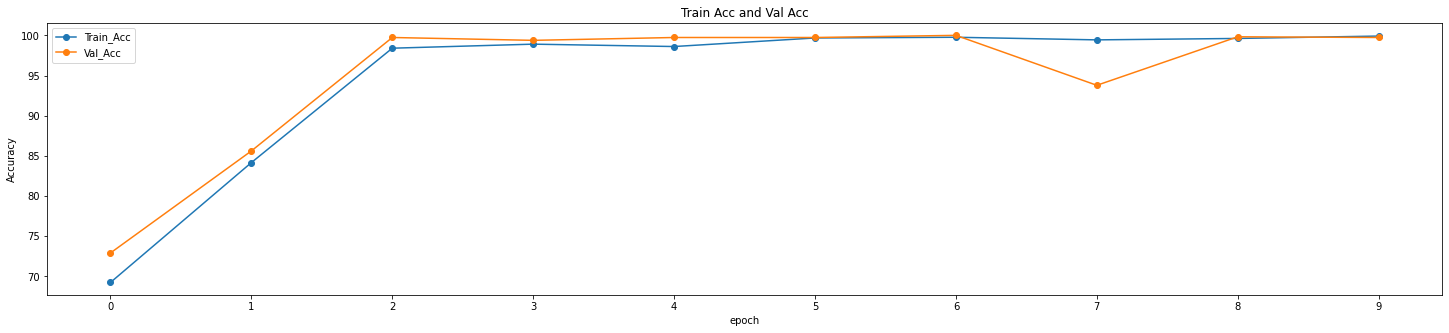

In [43]:
trainer.plot_his_acc()

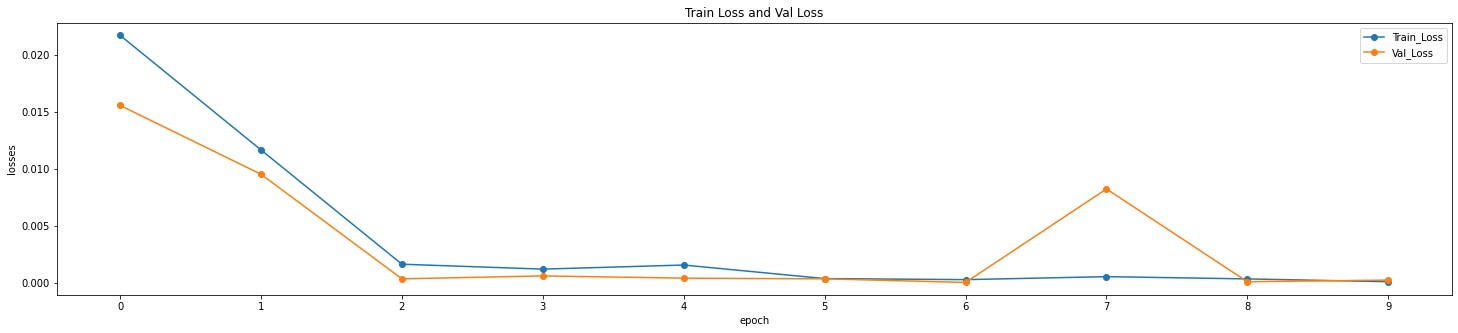

In [44]:
trainer.plot_his_loss()

In [45]:
def evaluate_model(model, loader):
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        running_loss=0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            pred_list.extend(predictions.cpu().numpy())
            label_list.extend(labels.cpu().numpy())
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    return acc,pred_list,label_list

In [46]:
acc, pred_list,label_list = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 99.82253771073647 %
